# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

In [2]:
%%javascript
Jupyter.notebook.config.update({"load_extensions":{"calico-spell-check":true,
                                                  "calico-document-tools":true,
                                                  "calico-cell-tools":true}})


<IPython.core.display.Javascript object>

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **
This is a classification problem since we want to group the students into two classes, those that are in danger of failing and those that are not.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [3]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
%matplotlib inline  

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


In [4]:
'''
student_data.head
from IPython.display import display
with pd.option_context('display.max_columns', None):
    display(student_data.head(10))
'''    

"\nstudent_data.head\nfrom IPython.display import display\nwith pd.option_context('display.max_columns', None):\n    display(student_data.head(10))\n"

### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [5]:
len(student_data["passed"][student_data["passed"]=="no"])

130

In [6]:
len(list(student_data.columns))

31

In [7]:
from __future__ import division
# TODO: Calculate number of students
n_students = len(student_data.index)

# TODO: Calculate number of features
n_features = len(list(student_data.columns)) - 1 # since "passed" contains the outcome

# TODO: Calculate passing students
n_passed = len(student_data["passed"][student_data["passed"]=="yes"])

# TODO: Calculate failing students
n_failed = len(student_data["passed"][student_data["passed"]=="no"])

# TODO: Calculate graduation rate
grad_rate = 100* n_passed/n_students

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [8]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [9]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']



### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [10]:
print X_all.shape[0]

395


In [11]:
# TODO: Import any additional functionality you may need here
from  sklearn.cross_validation import train_test_split
# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test/X_all.shape[0], random_state=0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **
Three models that are appropriate for this problem are:
1. Decision Trees

  * Decision trees can be used in power system maintenance to predict power stability [1]. 
  * Decision trees  perform well in problems where we have non-linear relationships between variables provided that precautions are taken to prune the trees to avoid overfitting.
  * Decision trees tend to perform poorly in situation where the relationship between the features and the response are linear. This is because decision trees do not exploit the linear structure of the data. this is illustrated in the figure below (obtained from [2]).
  
  <img src="files/decision_tree_limitation2.png">
  
  * A decision trees model is a good candidate for this problem because for the following reasons [2,3]
  
    * There could be  nonlinear relationships between the features and the outcome
    * Decision trees Requires little data preparation.
    * The resulting model can be visualized graphically and will be easy to interpret and explain
  
2. Support Vector Machines (SVMs) 

  * SVMs have been substantially used in bioinformatics where high dimensional spaces are the norm. As an example, they are used to classify and validate cancer tissue samples [4]. 
  * SVMs perform well in high dimensional problems (feature_intensive data) like in text or genomics provided that an appropriate kernel is chosen.
  * SVMs are not suitable for very large data sets if the computational time and cost is a concern. Although SVMs are generally accurate [5], the compute and storage cost increase very rapidly with the number of training vectors [6]. also, If the number of features is much greater than the number of samples, the method is likely to give poor performances [6]. Furthermore, if there are non-linear relationships between the features and outcome, one has to choose an appropriate non-linear kernel. That is adding to the complexity of the model [2]. They also can't handle multi-class classification problem without an extension [6].
  
  * An SVMs model is a good candidate for this problem because for the following reasons [2,5,6]
  
    * They are generally accurate models
    * The training data is small, so the computational time and storage are not going to be a concern here
    * Theoretical guaranty again undefitting and overfitting [7] 


3. Gradient Boosting (GB)

  * GB algorithms are substantially used in industry it is  is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems [8]. For examples GB is used is for Web search ranking [8,9]. 
  * GB will perform well on reasonable data set where we have non-linear relationships between features and outcome.
  * Just like SVMs, GB is not suitable for very large data sets if the computational time and cost is a concern. This is because the algorithm doesn't scale well. It can hardly be parallelized due to the sequential nature of boosting  [8].
  
  * An GB model is a good candidate for this problem because for the following reasons [2,5,7]
  
    * They are generally accurate models
    * Robust to outliers 
    * The size of the training set is not a concern


### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [12]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    from sklearn.metrics import f1_score
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target, y_pred, pos_label='yes')

    #return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [14]:
# TODO: Import the three supervised learning models from sklearn
# from sklearn import model_A
from sklearn.tree import DecisionTreeClassifier
1# from sklearn import model_B
from sklearn import ensemble
# from skearln import model_C
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = ensemble.GradientBoostingClassifier(random_state=0)
clf_C = SVC()

# import preprocessing to scale data for SVM
from sklearn import preprocessing

#scale the variables to be between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled =  min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

#print "X_train", X_train[:10]
#print "X_train_scaled", X_train_scaled[:10]
# TODO: Set up the training set sizes
X_train_100 = X_train_scaled[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train_scaled[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train_scaled[:300]
y_train_300 = y_train[:300]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
# 'train_predict' for clf_A and training size 100
train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
# 'train_predict' for clf_A and training size 200
train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
# 'train_predict' for clf_A and training size 300
train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)

# 'train_predict' for clf_B and training size 100
train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
# 'train_predict' for clf_B and training size 200
train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
# 'train_predict' for clf_B and training size 300
train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)

# 'train_predict' for clf_C and training size 100
train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
# 'train_predict' for clf_C and training size 200
train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
# 'train_predict' for clf_C and training size 300
train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)


Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0011 seconds
Made predictions in 0.0001 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0004 seconds.
F1 score for test set: 0.4222.
Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0022 seconds
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0002 seconds.
F1 score for test set: 0.4048.
Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0032 seconds
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0001 seconds.
F1 score for test set: 0.8000.
Training a GradientBoostingClassifier using a training set size of 100. . .
Trained model in 0.0518 seconds
Made predictions in 0.0004 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0003 seconds.
F1 score for test set: 0.7207.
Training a GradientBoostingC

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - Decision Tree**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0011          |        0.0001          |        1         |     0.4222      |
| 200               |         0.0022          |        0.0002          |        1         |     0.4048      |
| 300               |         0.0032          |        0.0001          |        1         |     0.8000      |

** Classifer 2 - Gradient Boosting**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |           0.0650        |    0.0003              |       1          |      0.7207     |
| 200               |           0.0650        |    0.0003              |    0.9852        |      0.6772     |
| 300               |           0.0970        |    0.0003              |    0.9740        |      0.6281     |

** Classifer 3 - Support Vector Machines**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |      0.0015             |         0.0008         |     0.7805       |       0.7662    |
| 200               |      0.0039             |         0.0013         |     0.7988       |       0.7662    |
| 300               |      0.0069             |         0.0017         |     0.8142       |       0.7662    |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **
I chose the support vector machines model. Although the gradient boosting model seem to have a comparable accuracy on the runs above, the SVMs model train in significantly less time (an order of magnitude difference)

**Note:** I think running the algorithms just once in each case without cross validation might not be the best way to choose the best model. A more reasonable way of doing that is describe in the appendix below.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

Given some historical data on students performances, the support vector machines (SVMs) algorithm will try to find a relationships between the attributes of the students (school, age, sex ...) and the outcome (whether they passed or not). more explicitly, the algorithm does some transformations called the kernel trick on your data and then based on these transformations it finds an optimal boundary between the possible outputs (pass or fail in this case). It finds the boundary that separates classes by as wide a margin as possible. 

<img src = "files/linsep_svm_linear.png" width="500" height="100">


Once we have that relationship (mapping a set of features to "pass" or "fail"), we can use it to identify students who might need early intervention before they fail to graduate provided that we have the attributes (used to train the model) for those students.

The kernel trick is a crucial part of SVMs. This is because SVMs try to find a linear boundary between the classes, but the data is not always linearly separable as illustrated below [10].

<img src="files/nonsep_svm_linear.png" width="500" height="500"> 

The kernel trick is a way to transform a given space into some other (usually very high dimensional) space where the classes will be linearly separable. In other words, using the kernel trick, we can transform the data that is not linearly separable in the initial space to a higher dimensional space where a hyperplane could be found to separate the classes as illustrate below [10].

<img src="files/data_2d_to_3d_hyperplane.png" width="800" height="200">



### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [15]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.cross_validation import ShuffleSplit
# TODO: Create the parameters list you wish to tune
parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

# TODO: Initialize the classifier
clf = SVC()

# TODO: Make an f1 scoring function using 'make_scorer' 
def scoring_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = f1_score(y_true, y_predict, pos_label='yes') 
    
    # Return the score
    return score

f1_scorer = make_scorer(scoring_metric)

# Create cross-validation sets from the training data
cv_sets = ShuffleSplit(X_train_scaled.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=f1_scorer, cv=cv_sets)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train_scaled, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train_scaled, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test_scaled, y_test))

Made predictions in 0.0045 seconds.
Tuned model has a training F1 score of 0.8292.
Made predictions in 0.0016 seconds.
Tuned model has a testing F1 score of 0.7945.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** 

the F<sub>1</sub> score of the training and testing sets are 0.8292 and 0.7945 respectively. The score for the testing set is better that the testing set score of the untuned model. 

### Appendix

I think a more reasonable method for choosing the best model before tuning is to at least do some cross validation to avoid overfitting as described below. This is adapted from the blog post on Machine learning mastery [11].

For each model, a 10 fold cross validation is performed to reduce errors using the f1 score as scorer. The resulting score of the validation is then displayed on a boxplot. We can see that in this case, SVMs seem to be the best choice. Although Gradient boosting 

LR: 0.778713 (0.060587)
GB: 0.763746 (0.064961)
RF: 0.726543 (0.090302)
KNN: 0.753002 (0.075233)
CART: 0.698201 (0.064980)
NB: 0.767603 (0.091226)
SVM: 0.810482 (0.067856)


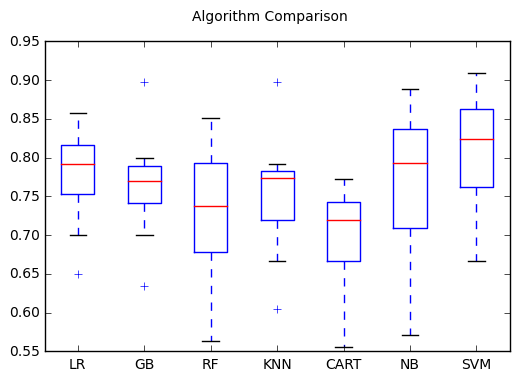

In [16]:
# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# prepare configuration for cross validation test harness
num_instances = len(X_train_300)
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('GB',ensemble.GradientBoostingClassifier()))
models.append(('RF',ensemble.RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []

for name, model in models:
	kfold = cross_validation.KFold(n=num_instances, n_folds=10, random_state=0)
	cv_results = cross_validation.cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=f1_scorer)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### References

[1] Senven Rovnyak, Stein Kretsinger, James Thorp, and Donald Brown. Decision trees for real time transient stability prediction. IEEE Transactions on Power Systems, 9(3):1417--1426, August 1994.

[2] Gareth, James; Witten, Daniela; Hastie, Trevor; Tibshirani, Robert (2015). An Introduction to Statistical Learning. New York: Springer. p. 315. ISBN 978-1-4614-7137-0

[3] Scikit-learn documentation. 2016.Decision Trees. [ONLINE] Available at: http://scikit-learn.org/stable/modules/tree.html. [Accessed 25 December 2016].

[4] Support vector machine classification and validation of cancer tissue samples using microarray expression data. Terrence S. Furey, Nello Cristianini, Nigel Duffy, David W. Bednarski, Michèl Schummer and David Haussler
*Bioinformatics* (2000) **16** (10): 906-914.doi: 10.1093/bioinformatics/16.10.906

[5] Manuel Fern´andez-Delgado, Eva Cernadas, Sen´en Barro and Dinani Amorim, Do we Need Hundreds of Classifiers to Solve Real World Classification Problems?, *Journal of Machine Learning Research* **15** (2014) 3133-3181 

[6] Scikit-learn documentation. 2016.1.4. Support Vector Machines. [ONLINE] Available at: http://scikit-learn.org/stable/modules/svm.html. [Accessed 25 December 2016].


[7] Kevin P. Murphy,  Machine Learning A Probabilistic Perspective. The MIT Press (2012).

[8] Scikit-learn documentation. 2016.1.11. Ensemble methods. [ONLINE] Available at:http://scikit-learn.org/stable/modules/ensemble.html. [Accessed 25 December 2016].

[9] Cossock, David and Zhang, Tong. Statistical Analysis of Bayes Optimal Subset Ranking *IEEE TRANSACTIONS ON INFORMATION THEORY*, VOL. **54**, NO. 11, (2008)

[10] Eric Kim. 2016. Everything You Wanted to Know about the Kernel Trick (But Were Too Afraid to Ask). [ONLINE] Available at: http://www.eric-kim.net/eric-kim-net/posts/1/kernel_trick.html. [Accessed 28 December 2016].

[11] Machine learning mastery. 2016. How To Compare Machine Learning Algorithms in Python with scikit-learn. [ONLINE] Available at: http://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/. [Accessed 23 December 2016].

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.